In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import glob
import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [2]:
DATA_DIR = "/home/smarkelova/Documents/Projects/recsys/recsys-course-spring-2025/hw2_done"

In [3]:
# Загрузка объединенных данных
data = pd.read_json(DATA_DIR + "/merged_data.json", lines=True)

In [4]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2025-04-10 03:36:16.843,4848,38316,0.82,0.000358,43292.0,{'PERSONALIZED': 'T1'}
1,next,2025-04-10 03:36:16.850,1838,30268,0.00,0.000431,1344.0,{'PERSONALIZED': 'T1'}
2,last,2025-04-10 03:36:16.852,1838,1344,0.00,0.000073,NaN,{'PERSONALIZED': 'T1'}
3,next,2025-04-10 03:36:16.855,4848,7847,0.00,0.000352,31300.0,{'PERSONALIZED': 'T1'}
4,next,2025-04-10 03:36:16.858,4848,31300,0.00,0.000399,46163.0,{'PERSONALIZED': 'T1'}


In [5]:
data.shape

(3329514, 8)

In [6]:
data.describe()

,timestamp,user,track,time,latency,recommendation
count,3329514,3.329514e+06,3.329514e+06,3.329514e+06,3.329514e+06,2.885781e+06
mean,2025-04-10 00:57:36.461874432,4.994823e+03,2.472297e+04,3.339274e-01,3.677660e-04,2.471035e+04
min,2025-04-09 19:05:16.078000,0.000000e+00,0.000000e+00,0.000000e+00,-9.341240e-03,0.000000e+00
25%,2025-04-09 19:12:44.626499840,2.497000e+03,1.235400e+04,0.000000e+00,3.161430e-04,1.228000e+04
50%,2025-04-10 03:43:19.833999872,4.986000e+03,2.469000e+04,2.100000e-01,3.671646e-04,2.467200e+04
75%,2025-04-10 03:53:57.727000064,7.502000e+03,3.697300e+04,6.300000e-01,4.272461e-04,3.699900e+04
max,2025-04-10 04:04:42.918000,9.999000e+03,4.999900e+04,1.000000e+00,1.045945e-01,4.999900e+04
std,NaN,2.888713e+03,1.431035e+04,3.654016e-01,2.399619e-04,1.433389e+04


In [7]:
# Загрузка метаданных треков
track_metadata = pd.read_json("/home/smarkelova/Documents/Projects/recsys/recsys-course-spring-2025/botify/data/tracks.json", lines=True).drop_duplicates(subset=["track"])

In [8]:
track_metadata.head()

,artist,album,title,genre,pop,duration,track
0,Михаил Бублик,ART-Обстрел I-часть,Сорок тысяч верст,"[1, 47]",-0.500252,282,41164
1,Xamdam Sobirov,Baxtli Bo'lolmadik,Baxtli Bo'lolmadik,[1],-0.942953,205,27544
2,Сергей Какенов,Ишимская шпана,Крутые лагеря,[147],-0.801382,252,34702
3,Loc-Dog,Electrodog 2,Еду убивать,[17],-0.577525,276,45907
4,Gafur,Февраль,Февраль,[1],-0.738636,160,14978


In [9]:
track_metadata.describe()

,pop,duration,track
count,50000.000000,50000.000000,50000.000000
mean,-0.442732,211.185880,24999.500000
std,0.689234,79.446348,14433.901067
min,-1.559756,29.000000,0.000000
25%,-0.887584,176.000000,12499.750000
50%,-0.620495,206.000000,24999.500000
75%,-0.218994,236.000000,37499.250000
max,5.139291,6704.000000,49999.000000


In [10]:
track_metadata.shape, track_metadata.isnull().sum(axis = 0)

((50000, 7),
 artist      0
 album       0
 title       0
 genre       0
 pop         0
 duration    0
 track       0
 dtype: int64)

In [11]:
positives = data[data["time"] > 0.75].copy()
positives["test"] = np.random.random(len(positives)) >= 0.8
positives.sort_values("time", ascending=False, inplace=True)
positives.drop_duplicates(["user", "track"], keep='first', inplace=True)

In [12]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 7].index.values)

In [15]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 3].index.values)

In [16]:
len(users), len(tracks)

(10000, 40609)

## Train LightFM

In [17]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(320881, 75809)

In [18]:
def prepare_item_features(track_metadata):
    # Оставляем только первый жанр
    track_metadata['main_genre'] = track_metadata['genre'].apply(
        lambda x: f"genre_{x[0]}" if len(x) > 0 else "genre_unknown"
    )
    
    track_metadata['artist_feature'] = 'artist_' + track_metadata['artist']
    
    # Обработка популярности
    track_metadata['pop_bucket'] = pd.qcut(
        track_metadata['pop'], 
        q=5, 
        labels=['pop_vlow', 'pop_low', 'pop_med', 'pop_high', 'pop_vhigh']
    )
    
    # Обработка длительности трека
    track_metadata['duration_bucket'] = pd.qcut(
        track_metadata['duration'],
        q=4,
        labels=['dur_short', 'dur_medshort', 'dur_medlong', 'dur_long']
    )
    
    return track_metadata[['track', 'main_genre', 'artist_feature', 'pop_bucket', 'duration_bucket']]

item_features_df = prepare_item_features(track_metadata)

In [19]:
item_features_df.head()

,track,main_genre,artist_feature,pop_bucket,duration_bucket
0,41164,genre_1,artist_Михаил Бублик,pop_med,dur_long
1,27544,genre_1,artist_Xamdam Sobirov,pop_vlow,dur_medshort
2,34702,genre_147,artist_Сергей Какенов,pop_low,dur_long
3,45907,genre_17,artist_Loc-Dog,pop_med,dur_long
4,14978,genre_1,artist_Gafur,pop_low,dur_short


In [20]:
dataset = ld.Dataset()
dataset.fit(users, tracks, 
        item_features=pd.concat([
        item_features_df['main_genre'],
        item_features_df['artist_feature'],
        item_features_df['pop_bucket'],
        item_features_df['duration_bucket']
    ]).unique())

In [21]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [22]:
# Строим item features
filtered_item_features = item_features_df[item_features_df['track'].isin(tracks)]

item_features = dataset.build_item_features(
    (row.track, [row.main_genre, row.artist_feature, row.pop_bucket, row.duration_bucket]) 
    for row in filtered_item_features.itertuples()
)

In [27]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=4,
    epsilon=1e-6,
    train_interactions=None,
    test_interactions=None,
    item_features=None
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, item_features=item_features, num_threads=threads)
        
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, item_features=item_features, k=at, num_threads=threads)
        
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        precisions_at.append(np.mean(precision_at))
            
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            break
        
    else:
        if verbose:
            print("No early stopiing happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [100, 130, 160, 190, 210, 240, 270])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 30, 35, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.0001])
    item_features = dataset.build_item_features(
        (row.track, [row.main_genre, row.artist_feature, row.pop_bucket, row.duration_bucket]) 
        for row in filtered_item_features.itertuples()
    )
    
    model, precisions_at = fit_model(
        epochs=20, 
        at=15,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
        train_interactions=train_interactions,
        test_interactions=test_interactions,
        item_features=item_features
    )
    
    return precisions_at[-1]

In [28]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)


[I 2025-05-01 00:46:16,347] A new study created in memory with name: no-name-619b22f4-e23b-4dd8-9288-13d0eb334fcd
[I 2025-05-01 00:51:44,348] Trial 0 finished with value: 0.000521042151376605 and parameters: {'loss': 'bpr', 'no_components': 190, 'learning_rate': 0.01, 'max_sampled': 100, 'user_alpha': 0.001, 'item_alpha': 0.0}. Best is trial 0 with value: 0.000521042151376605.
[I 2025-05-01 00:53:59,940] Trial 1 finished with value: 0.0011088845785707235 and parameters: {'loss': 'warp', 'no_components': 130, 'learning_rate': 0.0001, 'max_sampled': 10, 'user_alpha': 0.0, 'item_alpha': 0.0001}. Best is trial 1 with value: 0.0011088845785707235.
[I 2025-05-01 00:56:30,350] Trial 2 finished with value: 0.0002805611293297261 and parameters: {'loss': 'bpr', 'no_components': 190, 'learning_rate': 0.001, 'max_sampled': 35, 'user_alpha': 0.0001, 'item_alpha': 0.0001}. Best is trial 1 with value: 0.0011088845785707235.
[I 2025-05-01 01:00:05,199] Trial 3 finished with value: 0.001022044103592634

In [29]:
best_params = study.best_params
print(best_params)

{'loss': 'warp', 'no_components': 270, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.0, 'item_alpha': 0.0}


In [ ]:
# best_params = {'loss': 'warp', 'no_components': 270, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.0, 'item_alpha': 0.0}

In [30]:
model, precisions_at = fit_model(
    epochs=300,
    at=30,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
    train_interactions=train_interactions,
    test_interactions=test_interactions,
    item_features=item_features
)

0:	0.0010187041480094194 +/- 0.0001318612674448464
1:	0.0014395458856597543 +/- 0.0001625371548253402
2:	0.001913827727548778 +/- 0.00020369785201933242
3:	0.0023279895540326834 +/- 0.00022453762936604455
4:	0.0028590518049895763 +/- 0.0002469245872982937
5:	0.0032498331274837255 +/- 0.00026754825929052687
6:	0.0035838342737406492 +/- 0.0002844364167521435
7:	0.0038844358641654253 +/- 0.00029825277921439336
8:	0.004104877356439829 +/- 0.00030381832804554935
9:	0.00441215792670846 +/- 0.00031656424999190866
10:	0.004635938908904791 +/- 0.00032172216422823337
11:	0.004879760090261698 +/- 0.00032897816599501256
12:	0.005043420474976301 +/- 0.00033647598210703343
13:	0.005310621578246355 +/- 0.00034423001106089954
14:	0.005477622617036104 +/- 0.00034940912105364564
15:	0.005637942813336849 +/- 0.00035416033257753345
16:	0.005915164481848478 +/- 0.0003649031824532582
17:	0.006138944998383522 +/- 0.00037042705238752015
18:	0.006382766179740429 +/- 0.0003786422352211815
19:	0.0065931868739426

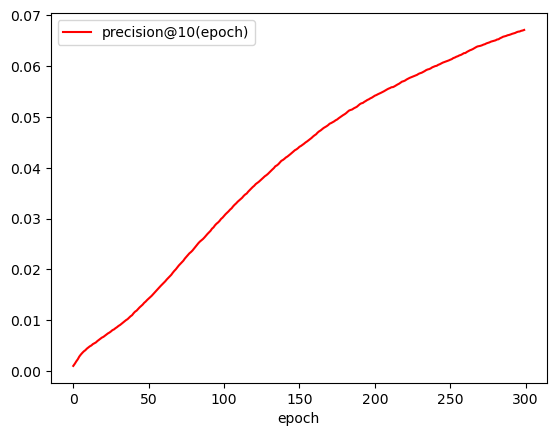

In [31]:
# Plot learning curve precision@k(epoch)
figure, ax = pl.subplots()

ax.plot(list(range(len(precisions_at))), precisions_at, "r", label="precision@10(epoch)")

ax.set_xlabel("epoch")
ax.legend()

pass

In [32]:
# Генерация рекомендаций
def generate_recommendations(model, dataset, users, item_features, k=100):
    all_tracks = list(dataset.mapping()[2].values())
    item_id_map = {v: k for k, v in dataset.mapping()[2].items()}

    popular_tracks = train_data['track'].value_counts().head(k).index.tolist()
    
    recommendations = {}
    
    for user in tqdm.tqdm(users):
        try:
            user_id = dataset.mapping()[0][user]
            
            # Предсказание scores с учетом item features
            scores = model.predict(
                user_ids=user_id,
                item_ids=np.arange(len(all_tracks)),
                item_features=item_features
            )
            
            top_items = np.argsort(-scores)[:k]
            recommended_tracks = [item_id_map[item] for item in top_items]
            
        except KeyError:
            recommended_tracks = popular_tracks
            
        recommendations[user] = recommended_tracks
    
    return recommendations

# Получение рекомендаций для всех пользователей
all_users = data["user"].unique()
recommendations = generate_recommendations(model, dataset, all_users, item_features)

100%|█████████████████████████████████████| 10000/10000 [05:21<00:00, 31.10it/s]


In [33]:
# Сохранение в JSON
with open(DATA_DIR + "/recommendations_hw2.json", "w") as rf:
    for user, tracks in recommendations.items():
        recommendation = {
            "user": int(user),
            "tracks": [int(track) for track in tracks]
        }
        rf.write(json.dumps(recommendation) + "\n")